# Time series Forescasting Stocks

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

## 1. Download stock price 

In [16]:
# Descargar datos históricos de las acciones del Grupo Aval y gruardarlas en un CSV

ticker_name = 'MSFT'

data = yf.download(ticker_name, start='2020-01-01', end=dt.date.today())
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
(871, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,155.422073,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,153.486786,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,153.883499,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,152.480423,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,154.909195,27746500


In [17]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index).date
df["Close"] = data["Close"].values
df.head()

,Date,Close
0,2020-01-02,160.619995
1,2020-01-03,158.619995
2,2020-01-06,159.029999
3,2020-01-07,157.580002
4,2020-01-08,160.089996


## 2. Visualization candlestick chart

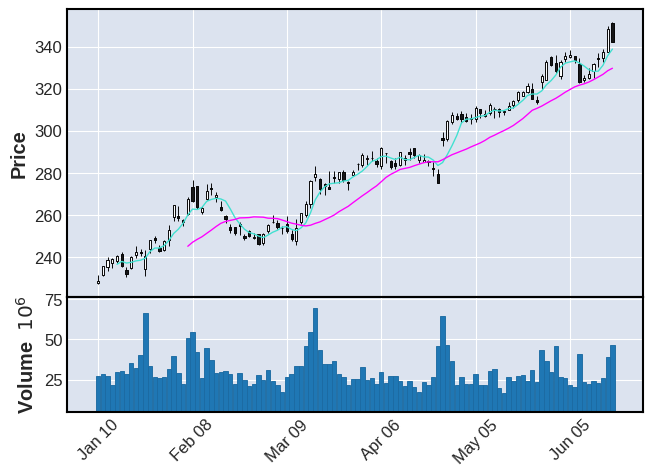

In [18]:
import mplfinance as mpf

data_visual = data.iloc[len(data)-110:]

mpf.plot(data_visual, type='candle', mav=(5,20), volume=True)

In [19]:
def MACD(df, window_slow, window_fast, window_signal):
    macd = pd.DataFrame()
    macd['ema_slow'] = df['Close'].ewm(span=window_slow).mean()
    macd['ema_fast'] = df['Close'].ewm(span=window_fast).mean()
    macd['macd'] = macd['ema_slow'] - macd['ema_fast']
    macd['signal'] = macd['macd'].ewm(span=window_signal).mean()
    macd['diff'] = macd['macd'] - macd['signal']
    macd['bar_positive'] = macd['diff'].map(lambda x: x if x > 0 else 0)
    macd['bar_negative'] = macd['diff'].map(lambda x: x if x < 0 else 0)
    return macd


In [20]:
def Stochastic(df, window, smooth_window):
    stochastic = pd.DataFrame()
    stochastic['%K'] = ((df['Close'] - df['Low'].rolling(window).min()) \
                        / (df['High'].rolling(window).max() - df['Low'].rolling(window).min())) * 100
    stochastic['%D'] = stochastic['%K'].rolling(smooth_window).mean()
    stochastic['%SD'] = stochastic['%D'].rolling(smooth_window).mean()
    stochastic['UL'] = 80
    stochastic['DL'] = 20
    return stochastic


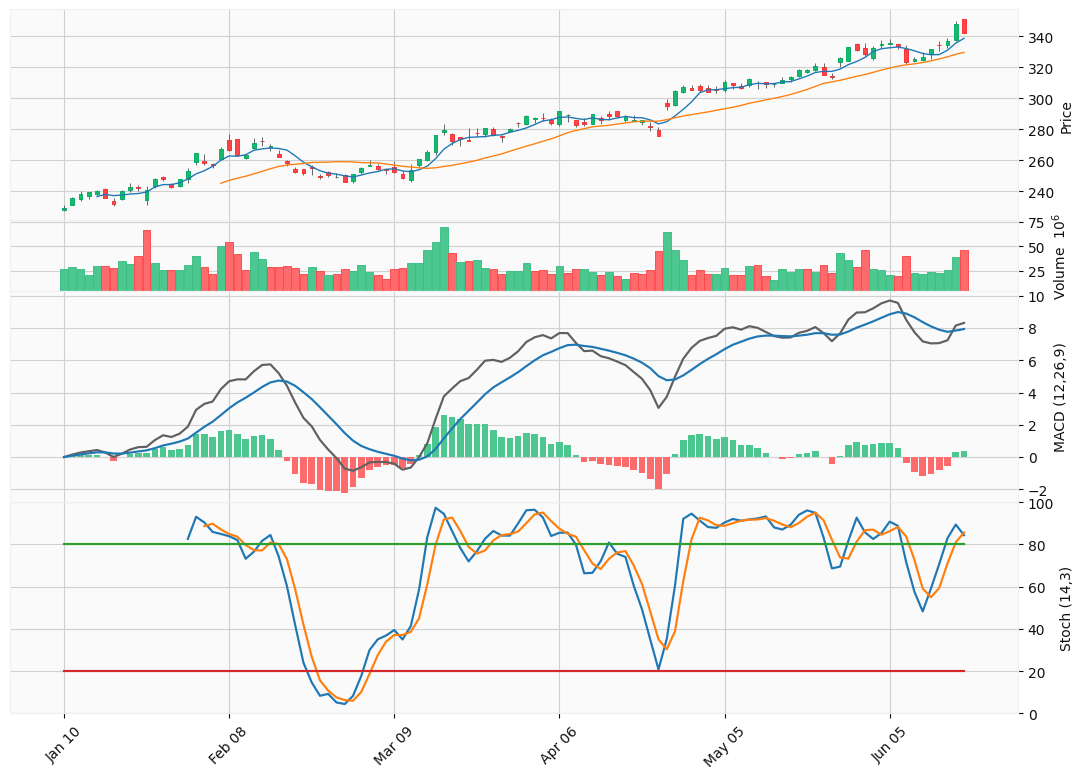

In [21]:
macd = MACD(data_visual, 12, 26, 9)
stochastic = Stochastic(data_visual, 14, 3)
plots  = [
    mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD (12,26,9)', secondary_y=False),
    mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
    mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
    mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2),
    mpf.make_addplot((stochastic[['%D', '%SD', 'UL', 'DL']]),
                     ylim=[0, 100], panel=3, ylabel='Stoch (14,3)')
]
mpf.plot(data_visual, type='candle', style='yahoo', mav=(5,20), volume=True, addplot=plots, panel_ratios=(3,1,3,3), figscale=1.75)

## 3. Statistics

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def ADF_ACF_PACF(df, lags):
    # Se observa claramente que no es estacionario,
    # pero por seguridad se usa el test ADG

    dftest = adfuller(df, autolag="AIC")
    test = ["ADF", "P-value"]
    for i in range(len(test)):
        print(f"{i+1}. {test[i]} : {dftest[i]:.8f}")

    fig, ax = plt.subplots(1,2,figsize=(16,3))
    plot_acf(df, lags=lags, ax=ax[0])
    plot_pacf(df, lags=lags, ax=ax[1])
    plt.show()
    


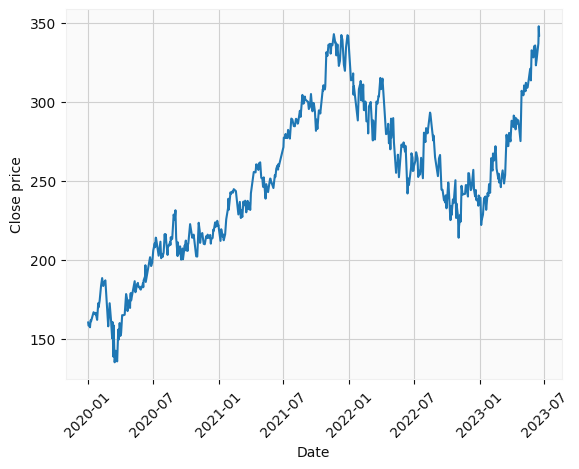

1. ADF : -1.30581930
2. P-value : 0.62650579


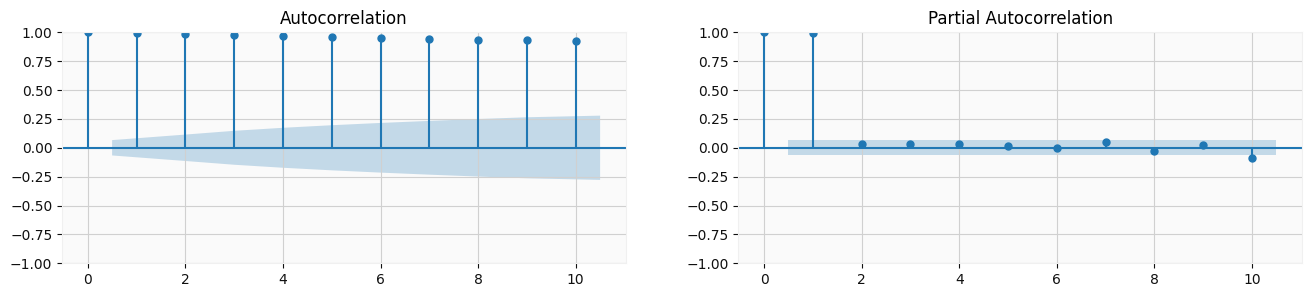

In [23]:

plt.plot(df["Date"], df["Close"])
plt.xlabel("Date")
plt.ylabel("Close price")
plt.xticks(rotation=45)
plt.show()

ADF_ACF_PACF(df['Close'], 10)

### 3.1 Stationary by diff

1. ADF : -9.61191901
2. P-value : 0.00000000


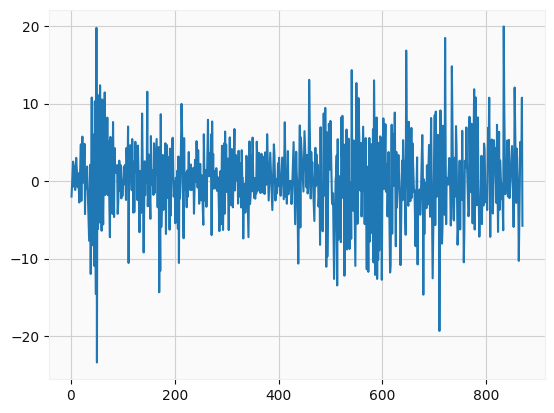

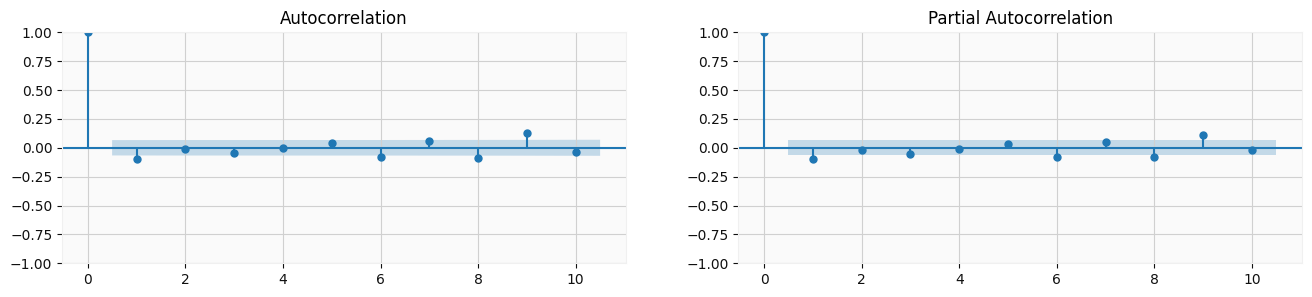

In [24]:
df_diff = df.diff().dropna()
df_diff['Close'].plot()
ADF_ACF_PACF(df_diff['Close'], 10)

### 3.2 Seasonal decompose

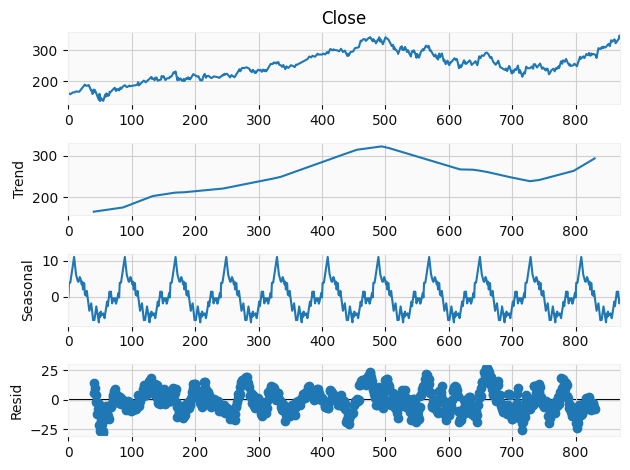

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["Close"], model="additive", period=80).plot()


## 4. Preparation for Models

In [26]:
df_prophet = df
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2020-01-02,160.619995
1,2020-01-03,158.619995
2,2020-01-06,159.029999
3,2020-01-07,157.580002
4,2020-01-08,160.089996


## 5. Prophet

### 5.1 Tunning Parameters

In [27]:
import itertools

param_grid = {  
    # tuning those parameters can potentially improve the performance of our model
    'changepoint_prior_scale': [0.001, 0.1],
#    'seasonality_prior_scale': [0.01, 1.0],
#    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

# Quick peek at what our combinations look like
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}]

In [28]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial = '100 days', period = '30 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:0

   changepoint_prior_scale seasonality_mode        rmse
0                    0.001         additive  355.509419
1                    0.001   multiplicative  389.640178
2                    0.100         additive  208.211048
3                    0.100   multiplicative  502.997163
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'}


### 5.2 Forecasting Prophet

In [29]:
m_pro = m = Prophet(changepoint_prior_scale=0.1, seasonality_mode ='additive', weekly_seasonality=False)
m_pro.fit(df_prophet)

19:46:35 - cmdstanpy - INFO - Chain [1] start processing
19:46:35 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
future_pro = m_pro.make_future_dataframe(periods=60)
future_pro.tail()

,ds
926,2023-08-11
927,2023-08-12
928,2023-08-13
929,2023-08-14
930,2023-08-15


In [31]:
forecast_pro = m_pro.predict(future_pro)
forecast_pro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
926,2023-08-11,380.689336,367.303355,394.622745
927,2023-08-12,381.596972,368.139767,396.201023
928,2023-08-13,382.462556,369.106996,396.375064
929,2023-08-14,383.279778,369.158756,398.024267
930,2023-08-15,384.042726,370.012606,398.319362


In [32]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m_pro, forecast_pro)

In [33]:
plot_components_plotly(m_pro, forecast_pro)

### 5.3 Performance evaluation

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def performance(forecast, ds="ds", y="y", y_predict="yhat"):
    metric_df_pro = forecast.set_index(ds)[[y_predict]].join(df.set_index(ds)[y]).reset_index()
    metric_df_pro.dropna(inplace=True)
    avg = metric_df_pro[y_predict].mean()
    r2 = r2_score(metric_df_pro[y], metric_df_pro[y_predict])
    mse = mean_squared_error(metric_df_pro[y], metric_df_pro[y_predict])
    mae = mean_absolute_error(metric_df_pro[y], metric_df_pro[y_predict])
    return avg, r2, mse, mae

In [103]:
avg_pro, r2_pro, mse_pro, mae_pro = performance(forecast_pro)

print(f"El promedio de las acciones es de: {avg_pro:.3f}")
print(f"El coeficiente de correlación es: {r2_pro:.3f}")
print(f"El errror medio al cuadrado es: {mse_pro:.3f}")
print(f"El errror absoluto medio es: {mae_pro:.3f}")

El promedio de las acciones es de: 250.398
El coeficiente de correlación es: 0.973
El errror medio al cuadrado es: 61.362
El errror absoluto medio es: 6.134


## 6. Neural Prophet

In [36]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

m = NeuralProphet()

metrics = m.fit(df_prophet)

Finding best initial lr:   0%|          | 0/224 [00:00<?, ?it/s]

2023-06-19 19:46:39.824773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 19:46:40.611321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training: 0it [00:00, ?it/s]

### 6.1 Forescasting NeuralProphet

In [37]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=60)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

Predicting: 55it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '2f186e42-90fc-4dfc-83f1-e687f5e038f8',
              'x': array([datetime.datetime(2020, 1, 2, 0, 0),
                          datetime.datetime(2020, 1, 3, 0, 0),
                          datetime.datetime(2020, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0),
                          datetime.datetime(2023, 9, 8, 0, 0)], dtype=object),
              'y': array([172.53164673, 171.47198486, 168.91664124, ..., 351.65759277,
                          351.01763916, 349.81954956])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'uid': '

In [38]:
m.plot_parameters(components=["trend", "seasonality"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'type': 'scatter',
              'uid': 'b395c444-6b03-4ba2-92b9-0c78692d16d2',
              'x': array([datetime.datetime(2020, 1, 2, 0, 0),
                          datetime.datetime(2020, 1, 3, 0, 0),
                          datetime.datetime(2020, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 6, 14, 0, 0),
                          datetime.datetime(2023, 6, 15, 0, 0),
                          datetime.datetime(2023, 6, 16, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([160.79663869, 160.43403013, 159.34620445, ..., 265.8824319 ,
                          266.14435878, 266.40628565]),
              'yaxis': 'y'},
             {'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              '

### 6.2 Performance Evaluation

In [104]:
avg_neural, r2_neural, mse_neural, mae_neural = performance(forecast, y_predict="yhat1")

print(f"El promedio de las acciones es de: {avg_neural:.3f}")
print(f"El coeficiente de correlación es: {r2_neural:.3f}")
print(f"El errror medio al cuadrado es: {mse_neural:.3f}")
print(f"El errror absoluto medio es: {mae_neural:.3f}")

El promedio de las acciones es de: 250.390
El coeficiente de correlación es: 0.963
El errror medio al cuadrado es: 82.710
El errror absoluto medio es: 7.190


In [113]:
data_result = {
    "Modelo": ["Neural Prophet", "Prophet"],
    "Promedio": [avg_neural, avg_pro],
    "R2": [r2_neural, r2_pro],
    "MSE": [mse_neural, mse_pro],
    "MAE": [mae_neural, mae_pro]
}

df_resultados = pd.DataFrame(data_result)

df_resultados_transpuesta = df_resultados.transpose().reset_index()

# Asignar los nombres de las columnas
df_resultados_transpuesta.columns = df_resultados_transpuesta.iloc[0]

# Eliminar la fila de nombres de columna extra
df_resultados_transpuesta = df_resultados_transpuesta[1:]

print(df_resultados_transpuesta.to_string(index=False))

  Modelo Neural Prophet     Prophet
Promedio     250.390326  250.397802
      R2       0.963001    0.972551
     MSE      82.710379    61.36186
     MAE       7.190479    6.133661


## 7. Forecasting Average 

In [41]:
f_neural = forecast[['ds', 'yhat1', 'y']]
f_neural.columns = ['Date', 'y_neural', 'y']
f_neural['y_neural_upper'] = f_neural['y_neural']*1.05
f_neural['y_neural_lower'] = f_neural['y_neural']*.95
f_neural.head()

,Date,y_neural,y,y_neural_upper,y_neural_lower
0,2020-01-02,172.531647,160.619995,181.158229,163.905064
1,2020-01-03,171.471985,158.619995,180.045584,162.898386
2,2020-01-06,168.916641,159.029999,177.362473,160.470809
3,2020-01-07,168.008896,157.580002,176.409341,159.608451
4,2020-01-08,167.943268,160.089996,176.340431,159.546104


In [42]:
f_pro = forecast_pro[['yhat', 'yhat_lower', 'yhat_upper']]
f_pro.columns = ['y_pro', 'y_pro_lower', 'y_pro_upper']
f_pro.head()

,y_pro,y_pro_lower,y_pro_upper
0,174.813698,164.240518,185.467464
1,173.631801,163.723638,183.783931
2,170.041156,159.959715,180.150687
3,168.871917,158.028040,178.837595
4,167.739663,158.180413,178.412327


In [43]:
f = pd.concat([f_neural, f_pro], axis=1)
f['y_predict'] = (f['y_neural'] + f['y_pro'])/2
f['y_predict_upper'] = (f['y_neural_upper'] + f['y_pro_upper'])/2
f['y_predict_lower'] = (f['y_neural_lower'] + f['y_pro_lower'])/2

f.head()

,Date,y_neural,y,y_neural_upper,y_neural_lower,y_pro,y_pro_lower,y_pro_upper,y_predict,y_predict_upper,y_predict_lower
0,2020-01-02,172.531647,160.619995,181.158229,163.905064,174.813698,164.240518,185.467464,173.672672,183.312847,164.072791
1,2020-01-03,171.471985,158.619995,180.045584,162.898386,173.631801,163.723638,183.783931,172.551893,181.914758,163.311012
2,2020-01-06,168.916641,159.029999,177.362473,160.470809,170.041156,159.959715,180.150687,169.478899,178.756580,160.215262
3,2020-01-07,168.008896,157.580002,176.409341,159.608451,168.871917,158.028040,178.837595,168.440406,177.623468,158.818246
4,2020-01-08,167.943268,160.089996,176.340431,159.546104,167.739663,158.180413,178.412327,167.841466,177.376379,158.863259


In [189]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

# Agregar las líneas y_neural con sus límites
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_neural"],
    name="NeuralProphet Forescasting",
    line=dict(color='blue', width=2)
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_neural_upper"],
    name="NeuralProphet upper limit",
    line=dict(color='blue', width=1, dash='dash'),
    
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_neural_lower"],
    name="NeuralProphet lower limit",
    line=dict(color='blue', width=1, dash='dash'),
    
))

# Agregar las líneas y_pro con sus límites
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_pro"],
    name="Prophet Forescasting",
    line=dict(color='red', width=2)
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_pro_upper"],
    name="Prophet upper limit",
    line=dict(color='red', width=1, dash='dash'),
    
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_pro_lower"],
    name="Prophet lower limit",
    line=dict(color='red', width=1, dash='dash'),
    
))

# Agregar las líneas y_predict con sus límites
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_predict"],
    name="Prediction mean",
    line=dict(color='green', width=2)
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_predict_upper"],
    name="Prediction mean upper limit",
    line=dict(color='green', width=1, dash='dash'),
    
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_predict_lower"],
    name="Prediction mean lower limit",
    line=dict(color='green', width=1, dash='dash'),
    
))

# Agregar la línea y en color negro
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y"],
    name="Data",
    line=dict(color='black', width=2)
))

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)




# Agregar range slider a los ejes x e y
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

# Mostrar el gráfico interactivo
fig.show()




## 8. Data preparation RNN

In [46]:
df_train = f[['Date', 'y']].iloc[:866]
print(df_train.tail())

df_test = f[['Date', 'y_predict']].iloc[866:]
print(df_test.head())

          Date           y
861 2023-06-05  335.940002
862 2023-06-06  333.679993
863 2023-06-07  323.380005
864 2023-06-08  325.260010
865 2023-06-09  326.790009
          Date   y_predict
866 2023-06-12  332.414722
867 2023-06-13  333.156790
868 2023-06-14  334.286408
869 2023-06-15  335.352645
870 2023-06-16  336.137455


In [100]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_train['Date'], y=df_train['y'], mode='lines', name='Train Data', line=dict(color='blue')))
# Agregar una línea en rojo para la sección de prueba
fig.add_trace(go.Scatter(x=df_test['Date'], y=df_test['y_predict'], mode='lines', name='Test Data', line=dict(color='red')))

# Mostrar la figura
fig.show()

In [48]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD


train = df_train['y'].values
test = df_test['y_predict'].values

In [49]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = train.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [101]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [102]:
window_size = 3
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)
X_train[1:10]


array([[[0.11170494],
        [0.11367905],
        [0.10669751]],

       [[0.11367905],
        [0.10669751],
        [0.1187828 ]],

       [[0.10669751],
        [0.1187828 ],
        [0.12841254]],

       [[0.1187828 ],
        [0.12841254],
        [0.12480139]],

       [[0.12841254],
        [0.12480139],
        [0.13414224]],

       [[0.12480139],
        [0.13414224],
        [0.12860517]],

       [[0.13414224],
        [0.12860517],
        [0.13366073]],

       [[0.12860517],
        [0.13366073],
        [0.14805721]],

       [[0.13366073],
        [0.14805721],
        [0.15253508]]])

## 9. LSTM

### 9.1 Model

In [52]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="relu", input_shape=(window_size, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(15))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse', metrics=["mae"])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 25)                3150      
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 67,056
Trainable params: 67,056
Non-trainable params: 0
_________________________________________________________________


2023-06-19 19:47:25.650710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [53]:
num_epochs = 15
num_batch = 32
history = model_lstm.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch)

Epoch 1/15
27/27 [==============================] - 2s 4ms/step - loss: 0.1532 - mae: 0.3069
Epoch 2/15
27/27 [==============================] - 0s 4ms/step - loss: 0.0198 - mae: 0.1154
Epoch 3/15
27/27 [==============================] - 0s 4ms/step - loss: 0.0079 - mae: 0.0700
Epoch 4/15
27/27 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0285
Epoch 5/15
27/27 [==============================] - 0s 3ms/step - loss: 8.6253e-04 - mae: 0.0227
Epoch 6/15
27/27 [==============================] - 0s 4ms/step - loss: 8.3268e-04 - mae: 0.0221
Epoch 7/15
27/27 [==============================] - 0s 4ms/step - loss: 7.9111e-04 - mae: 0.0215
Epoch 8/15
27/27 [==============================] - 0s 4ms/step - loss: 8.3327e-04 - mae: 0.0223
Epoch 9/15
27/27 [==============================] - 0s 4ms/step - loss: 8.0137e-04 - mae: 0.0215
Epoch 10/15
27/27 [==============================] - 0s 4ms/step - loss: 8.0028e-04 - mae: 0.0219
Epoch 11/15
27/27 [==========================

### 9.2 Performance Evaluation

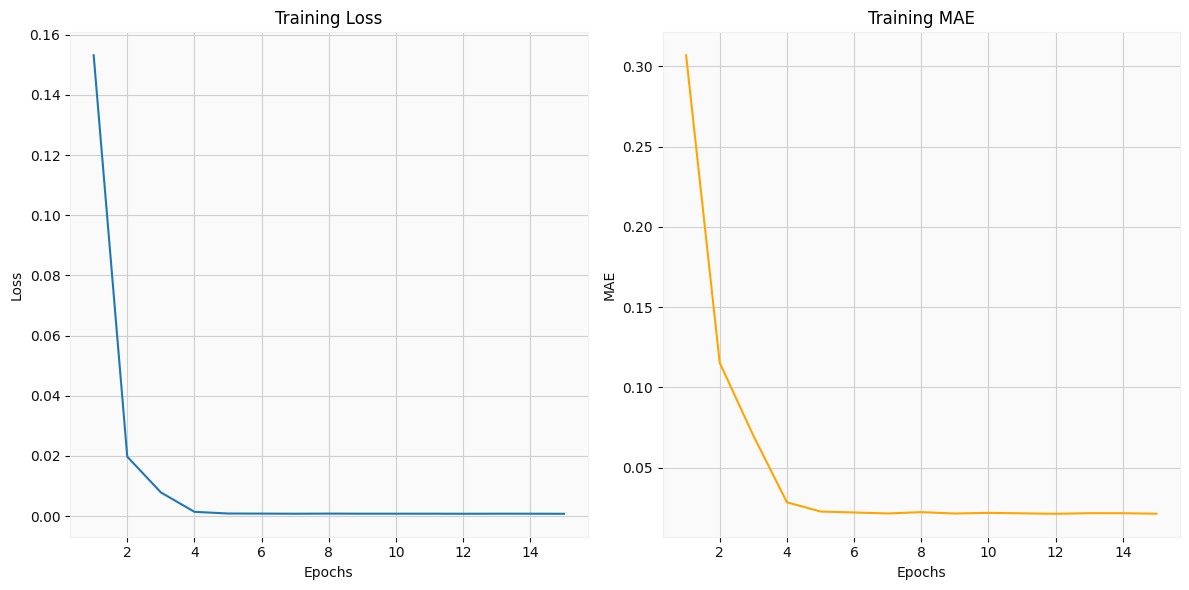

In [54]:
# Obtener las métricas de pérdida y precisión
train_loss = history.history['loss']
train_mae = history.history['mae']

def plot_trainning(train_loss, train_mae):
    # Crear un subplot con 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Graficar la pérdida de entrenamiento
    ax1.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')

    # Graficar la precisión de entrenamiento
    ax2.plot(range(1, num_epochs+1), train_mae, label='Training MAE', color='orange')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Training MAE')

    # Ajustar el espacio entre subplots
    plt.tight_layout()

    # Mostrar la figura con los subplots
    plt.show()

plot_trainning(train_loss, train_mae)

In [126]:
loss = history.history['loss'][-1]
mae = history.history['mae'][-1]

print("MSE:", loss)
print("MAE:", mae)

MSE: 0.0007686151657253504
MAE: 0.021320752799510956


### 9.3 LSTM Forescasting

In [55]:
test = df_test['y_predict'].values
test = test.reshape(-1, 1)
test = sc.transform(test)

X_test, y_test = split_sequence(test, window_size)
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)


predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)


(62, 3, 1)
2/2 [==============================] - 0s 3ms/step


### 9.4 Performance Evaluation Tests

In [115]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

def performance_RNN_test(test, predicted):
    avg = predicted.mean()
    r2 = r2_score(test, predicted)
    mse = mean_squared_error(test, predicted)
    mae = mean_absolute_error(test, predicted)

    return avg, r2, mse, mae

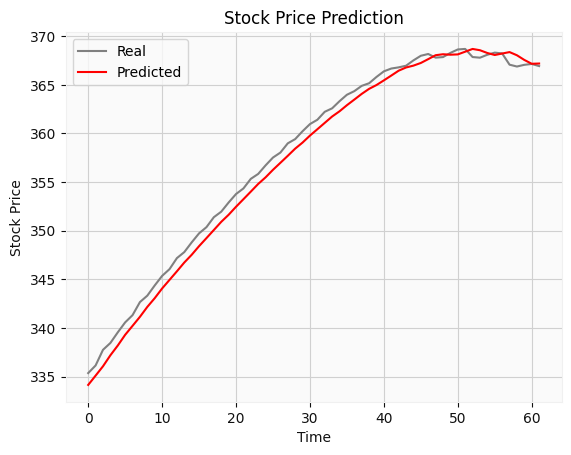

In [57]:
plot_predictions(y_test,predicted_stock_price)

In [116]:
avg_lstm_test, r2_lstm_test, mse_lstm_test, mae_lstm_test = performance_RNN_test(y_test,predicted_stock_price)
print(f"El promedio de las acciones es de: {avg_lstm_test:.3f}")
print(f"El coeficiente de correlación es: {r2_lstm_test:.3f}")
print(f"El errror medio al cuadrado es: {mse_lstm_test:.3f}")
print(f"El errror absoluto medio es: {mae_lstm_test:.3f}")

El promedio de las acciones es de: 357.052
El coeficiente de correlación es: 0.990
El errror medio al cuadrado es: 1.014
El errror absoluto medio es: 0.919


## 10. GRU

### 10.1 Model

In [59]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="relu", input_shape=(window_size, features)))
model_gru.add(Dense(units=25))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse", metrics=['mae'])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_3 (Dense)             (None, 25)                3150      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 51,176
Trainable params: 51,176
Non-trainable params: 0
_________________________________________________________________


In [60]:
history_gru = model_gru.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch)

Epoch 1/15
27/27 [==============================] - 1s 3ms/step - loss: 0.0710 - mae: 0.1962
Epoch 2/15
27/27 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0548
Epoch 3/15
27/27 [==============================] - 0s 3ms/step - loss: 8.0058e-04 - mae: 0.0221
Epoch 4/15
27/27 [==============================] - 0s 3ms/step - loss: 6.8518e-04 - mae: 0.0201
Epoch 5/15
27/27 [==============================] - 0s 3ms/step - loss: 6.6322e-04 - mae: 0.0196
Epoch 6/15
27/27 [==============================] - 0s 3ms/step - loss: 6.5412e-04 - mae: 0.0195
Epoch 7/15
27/27 [==============================] - 0s 3ms/step - loss: 6.5831e-04 - mae: 0.0195
Epoch 8/15
27/27 [==============================] - 0s 3ms/step - loss: 6.6601e-04 - mae: 0.0197
Epoch 9/15
27/27 [==============================] - 0s 3ms/step - loss: 6.7224e-04 - mae: 0.0197
Epoch 10/15
27/27 [==============================] - 0s 4ms/step - loss: 6.7451e-04 - mae: 0.0198
Epoch 11/15
27/27 [==================

### 10.2 Performance Evaluation

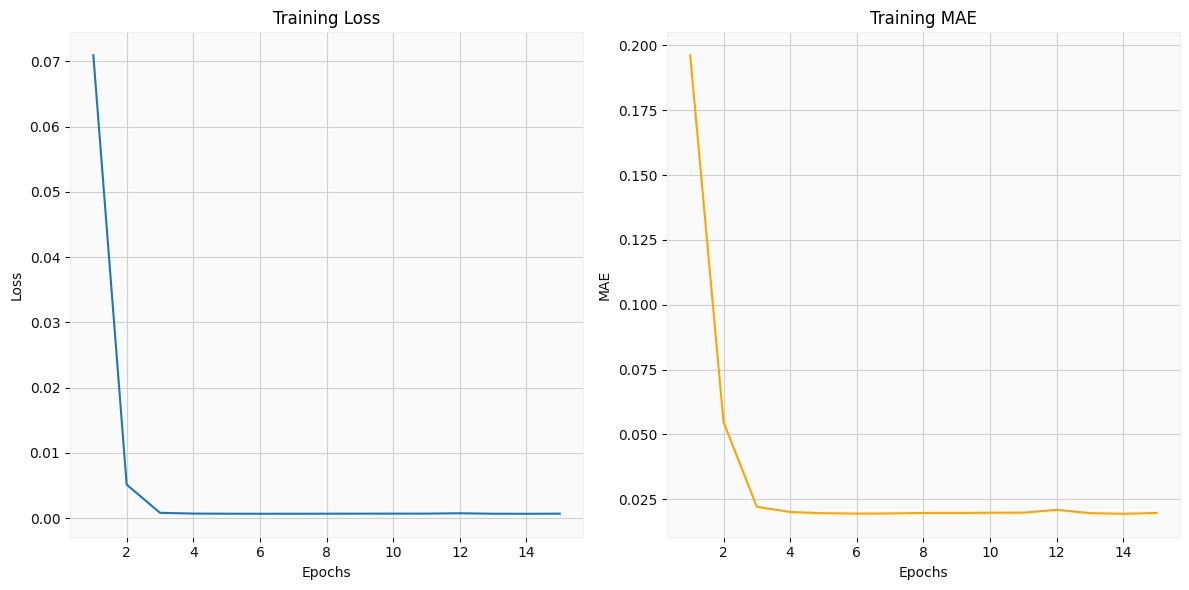

In [61]:
train_loss_gru = history_gru.history['loss']
train_mae_gru = history_gru.history['mae']

plot_trainning(train_loss_gru, train_mae_gru)

In [127]:
loss_gru = history_gru.history['loss'][-1]
mae_gru = history_gru.history['mae'][-1]

print("MSE:", loss_gru)
print("MAE:", mae_gru)

MSE: 0.0006724493578076363
MAE: 0.019697343930602074


In [131]:
print("                LSTM                  GRU")
print(f"MSE: {loss}     {loss_gru}")
print(f"MAE:  {mae}      {mae_gru}")

                LSTM                  GRU
MSE: 0.0007686151657253504     0.0006724493578076363
MAE:  0.021320752799510956      0.019697343930602074


### 10.3 GRU Forescasting

In [62]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

2/2 [==============================] - 0s 3ms/step


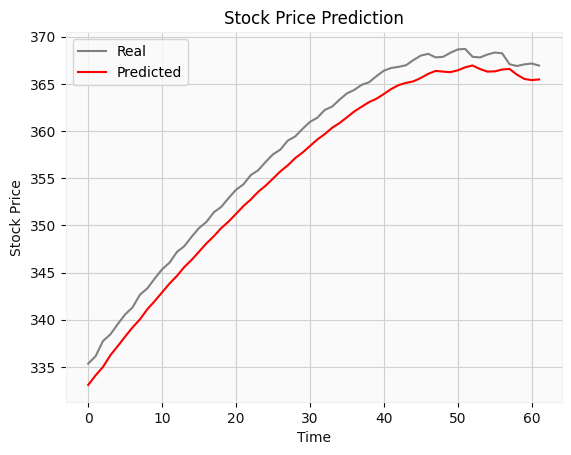

In [63]:
plot_predictions(y_test, GRU_predicted_stock_price)

### 10.4 Performance Evaluation Test

In [117]:
avg_gru_test, r2_gru_test, mse_gru_test, mae_gru_test = performance_RNN_test(y_test, GRU_predicted_stock_price)
print(f"El promedio de las acciones es de: {avg_gru_test:.3f}")
print(f"El coeficiente de correlación es: {r2_gru_test:.3f}")
print(f"El errror medio al cuadrado es: {mse_gru_test:.3f}")
print(f"El errror absoluto medio es: {mae_gru_test:.3f}")

El promedio de las acciones es de: 355.634
El coeficiente de correlación es: 0.954
El errror medio al cuadrado es: 4.856
El errror absoluto medio es: 2.158


In [118]:
data_result_1 = {
    "Modelo": ["LSTM Test", "GRU Test"],
    "Promedio": [avg_lstm_test, avg_gru_test],
    "R2": [r2_lstm_test, r2_gru_test],
    "MSE": [mse_lstm_test, mse_gru_test],
    "MAE": [mae_lstm_test, mae_gru_test]
}

df_resultados = pd.DataFrame(data_result_1)

df_resultados_transpuesta = df_resultados.transpose().reset_index()

# Asignar los nombres de las columnas
df_resultados_transpuesta.columns = df_resultados_transpuesta.iloc[0]

# Eliminar la fila de nombres de columna extra
df_resultados_transpuesta = df_resultados_transpuesta[1:]

print(df_resultados_transpuesta.to_string(index=False))

  Modelo  LSTM Test    GRU Test
Promedio  357.05191  355.633881
      R2   0.990471    0.954347
     MSE   1.013645    4.856454
     MAE   0.918828    2.157739


## 11. Prediction average final

In [135]:
print(f.shape)
f.head()

(931, 11)


,Date,y_neural,y,y_neural_upper,y_neural_lower,y_pro,y_pro_lower,y_pro_upper,y_predict,y_predict_upper,y_predict_lower
0,2020-01-02,172.531647,160.619995,181.158229,163.905064,174.813698,164.240518,185.467464,173.672672,183.312847,164.072791
1,2020-01-03,171.471985,158.619995,180.045584,162.898386,173.631801,163.723638,183.783931,172.551893,181.914758,163.311012
2,2020-01-06,168.916641,159.029999,177.362473,160.470809,170.041156,159.959715,180.150687,169.478899,178.756580,160.215262
3,2020-01-07,168.008896,157.580002,176.409341,159.608451,168.871917,158.028040,178.837595,168.440406,177.623468,158.818246
4,2020-01-08,167.943268,160.089996,176.340431,159.546104,167.739663,158.180413,178.412327,167.841466,177.376379,158.863259


In [149]:
f['y_gru'] = 0
num_predictions = len(GRU_predicted_stock_price)
f['y_gru'][869:869+num_predictions] = GRU_predicted_stock_price.flatten()
f['y_gru_upper'] = f['y_gru']*1.05
f['y_gru_lower'] = f['y_gru']*.95

In [150]:
f['y_lstm'] = 0
num_predictions = len(predicted_stock_price)
f['y_lstm'][869:869+num_predictions] = predicted_stock_price.flatten()
f['y_lstm_upper'] = f['y_lstm']*1.05
f['y_lstm_lower'] = f['y_lstm']*.95

In [157]:
f['y_predict'] = (f['y_neural'] + f['y_pro'] + f['y_lstm'] + f['y_gru']) / 4
f['y_predict_upper'] = (f['y_neural_upper'] + f['y_pro_upper'] + f['y_lstm_upper'] + f['y_gru_upper']) / 4

# Definir la columna 'y_predict_lower'
f['y_predict_lower'] = (f['y_neural_lower'] + f['y_pro_lower'] + f['y_lstm_lower'] + f['y_gru_lower']) / 4

# Aplicar las condiciones adicionales
f.loc[f['y_lstm'] == 0, 'y_predict'] = (f['y_neural'] + f['y_pro']) / 2
f.loc[(f['y_lstm'] != 0) & (f['y_gru'] != 0), 'y_predict'] = (f['y_neural'] + f['y_pro'] + f['y_lstm'] + f['y_gru']) / 4

f.loc[f['y_lstm'] == 0, 'y_predict_upper'] = (f['y_neural_upper'] + f['y_pro_upper']) / 2
f.loc[(f['y_lstm'] != 0) & (f['y_gru'] != 0), 'y_predict_upper'] = (f['y_pro_upper'] + f['y_lstm_upper'] + f['y_gru_upper'] + f['y_neural_upper']) / 4

f.loc[f['y_lstm'] == 0, 'y_predict_lower'] = (f['y_neural_lower'] + f['y_pro_lower']) / 2
f.loc[(f['y_lstm'] != 0) & (f['y_gru'] != 0), 'y_predict_lower'] = (f['y_pro_lower'] + f['y_lstm_lower'] + f['y_gru_lower'] + f['y_neural_lower']) / 4


In [229]:

f_limit = f.tail(num_predictions)

# Crear la gráfica interactiva utilizando Plotly Express y Plotly Graph Objects
fig = go.Figure()

# Agregar las líneas y_neural con sus límites
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_neural"],
    name="NeuralProphet Forescasting",
    line=dict(color='blue', width=2)
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_neural_upper"],
    name="NeuralProphet upper limit",
    line=dict(color='blue', width=1, dash='dash'),
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_neural_lower"],
    name="NeuralProphet lower limit",
    line=dict(color='blue', width=1, dash='dash'),
))

# Agregar las líneas y_pro con sus límites
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_pro"],
    name="Prophet Forescasting",
    line=dict(color='red', width=2)
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_pro_upper"],
    name="Prophet upper limit",
    line=dict(color='red', width=1, dash='dash'),
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_pro_lower"],
    name="Prophet lower limit",
    line=dict(color='red', width=1, dash='dash'),
))

# Agregar las líneas y_gru con sus límites
fig.add_trace(go.Scatter(
    x=f_limit["Date"],
    y=f_limit["y_lstm"],
    name="LSTM Forescasting",
    line=dict(color='purple', width=2)
))
fig.add_trace(go.Scatter(
    x=f_limit["Date"],
    y=f_limit["y_lstm_upper"],
    name="LSTM upper limit",
    line=dict(color='purple', width=1, dash='dash'),
))
fig.add_trace(go.Scatter(
    x=f_limit["Date"],
    y=f_limit["y_lstm_lower"],
    name="LSTM lower limit",
    line=dict(color='purple', width=1, dash='dash'),
))

# Agregar las líneas y_gru con sus límites
fig.add_trace(go.Scatter(
    x=f_limit["Date"],
    y=f_limit["y_gru"],
    name="GRU Forescasting",
    line=dict(color='orange', width=2)
))
fig.add_trace(go.Scatter(
    x=f_limit["Date"],
    y=f_limit["y_gru_upper"],
    name="GRU upper limit",
    line=dict(color='orange', width=1, dash='dash'),
))
fig.add_trace(go.Scatter(
    x=f_limit["Date"],
    y=f_limit["y_gru_lower"],
    name="GRU lower limit",
    line=dict(color='orange', width=1, dash='dash'),
))



# Agregar las líneas y_predict con sus límites
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_predict"],
    name="Prediction mean",
    line=dict(color='green', width=2)
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_predict_upper"],
    name="Prediction mean upper limit",
    line=dict(color='green', width=1, dash='dash'),
))
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y_predict_lower"],
    name="Prediction mean lower limit",
    line=dict(color='green', width=1, dash='dash'),
))


# Agregar la línea y en color negro
fig.add_trace(go.Scatter(
    x=f["Date"],
    y=f["y"],
    name="Data",
    line=dict(color='black', width=2)
))

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)
# Agregar range slider a los ejes x
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

# Almacenar el rango original del eje y
original_y_range = [f["y"].min(), f["y"].max()]

# Crear botones para aumentar/disminuir el eje y
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    label="Zoom In",
                    method="relayout",
                    args=[
                        {"yaxis.range": [fig.data[7].y.min(), fig.data[7].y.max()]}
                    ]
                ),
                dict(
                    label="Zoom Out",
                    method="relayout",
                    args=[
                        {"yaxis.range": original_y_range}
                    ]
                )
            ],
            active=-1,
            showactive=False,
            direction="up",
            pad={"r": 10, "t": 10},
            x=1.15,
            y=0.45
        )
    ]
)

# Mostrar el gráfico interactivo
fig.show()
